In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid


import matplotlib.pyplot as plt
from tqdm import *
import copy

import os
import tarfile
import numpy as np




/global/home/users/njo/anaconda3/envs/gaia/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /global/home/users/njo/anaconda3/envs/gaia/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warn(f"Failed to load image Python extension: {e}")


In [10]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda:0")
    elif torch.backends.mps.is_available():
        torch.mps.empty_cache()
        return torch.device("mps")
    else:
        return torch.device("cpu")

device = get_device()

print(device)

# Function to count number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


cuda:0


# MNIST

In [5]:
# Load dataset without any normalization
train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)

# Compute mean and std
data = torch.cat([img for img, _ in train_dataset], dim=0)
mean = torch.mean(data)
std = torch.std(data)

# Now, define the transform with computed mean and std
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])

# Reload dataset with normalization
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

# Data Loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)


In [6]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 50, bias=False)
        self.bn1 = nn.BatchNorm1d(50)
        self.fc2 = nn.Linear(50, 50, bias=False)
        self.bn2 = nn.BatchNorm1d(50)
        self.fc3 = nn.Linear(50, 10, bias=False)
        self.bn3 = nn.BatchNorm1d(10)
#         self.fc4 = nn.Linear(30, 10, bias=False)
#         self.bn4 = nn.BatchNorm1d(10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.bn1(F.relu(self.fc1(x)))
        x = self.bn2(F.relu(self.fc2(x)))
        x = self.bn3(F.relu(self.fc3(x)))
#         x = self.bn4(F.relu(self.fc4(x)))
        return F.log_softmax(x, dim=1)

In [7]:
# Functions
def evaluate_accuracy(model, data_loader, device=device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return 100 * correct / total



def evaluate_and_prune(model, test_loader, prune_step=50):
    # To store accuracies for each level of pruning
    accuracies = []
    
    # Clone the original model, so the original model remains unaffected
    model_copy = copy.deepcopy(model)
    
    # Create a list to hold all weights and their respective parameter tensor and index
    weight_info = []
    
    for param in model_copy.parameters():
        flattened_param = param.view(-1)
        for idx, w in enumerate(flattened_param):
            weight_info.append((w.item(), param, idx))
            
   
    # Sort the weight info list by the absolute value of the weights
    weight_info.sort(key=lambda x: abs(x[0]))
    
    # Loop to prune weights in steps and evaluate the model
    for i in tqdm(range(0, len(weight_info), prune_step)):
        # Zero out the smallest weights
        with torch.no_grad():
            for _, param, idx in weight_info[i:i+prune_step]:
                param.view(-1)[idx] = 0.0
        
        # Evaluate the accuracy of the pruned model
        accuracy = evaluate_accuracy(model_copy, test_loader)
        accuracies.append(accuracy)

    return accuracies

def get_sorted_weights(model):
    sorted_weights = []
    for param in model.parameters():
        sorted_weights.extend(torch.abs(param.detach()).cpu().numpy().flatten())
    sorted_weights = sorted(sorted_weights)
    return sorted_weights





In [8]:
def train_model(optimizer_type, device=device, weight_decay=0, lr=0.00001, num_epochs=20):
    model = SimpleNN()
    model = model.to(device)  # Move model to device
    torch.manual_seed(0)

    if optimizer_type == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_type == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_type == 'AdamL1':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else:
        raise ValueError("Invalid optimizer type")

    criterion = nn.CrossEntropyLoss()

    loss_list = []
    accuracy_list = []

    for epoch in tqdm(range(num_epochs)):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)  # Move data and target to device
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            
            if optimizer_type == 'AdamL1':
                l1_lambda = weight_decay
                l1_norm = sum(p.abs().sum() for p in model.parameters())
                loss += l1_lambda * l1_norm
            
            loss.backward()
            optimizer.step()

        val_loss = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)  # Move data and target to device
                output = model(data)
                loss = criterion(output, target)
                val_loss += loss.item()

        loss_list.append(val_loss / len(test_loader))

        accuracy = evaluate_accuracy(model, test_loader, device)
        accuracy_list.append(accuracy)

    return loss_list, accuracy_list, model



In [9]:
epochs=10
# Training and getting losses and weights
adam_loss_0, adam_accuracy_0, adam_model_0 = train_model('Adam',num_epochs=epochs, lr=0.0001)
adamL2_loss, adamL2_accuracy, adamL2_model = train_model('Adam',weight_decay=0.02,num_epochs=epochs, lr=0.0001)
adamW_loss, adamW_accuracy, adamW_model = train_model('AdamW',weight_decay=0.02,num_epochs=epochs, lr=0.0001)
adamL1_loss, adamL1_accuracy, adamL1_model = train_model('AdamL1',weight_decay=0.002,num_epochs=epochs, lr=0.0001)





100%|███████████████████████████████████████████| 10/10 [01:55<00:00, 11.58s/it]


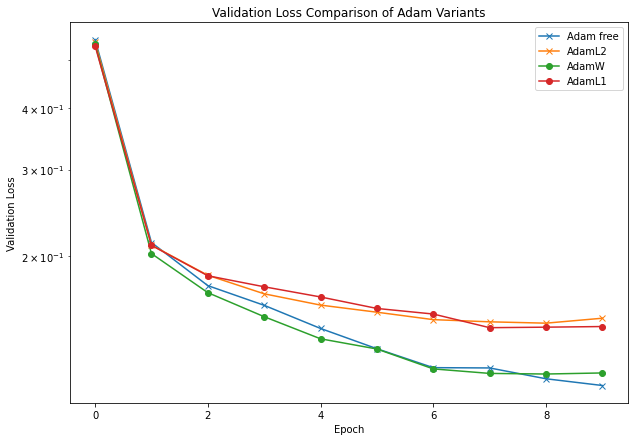

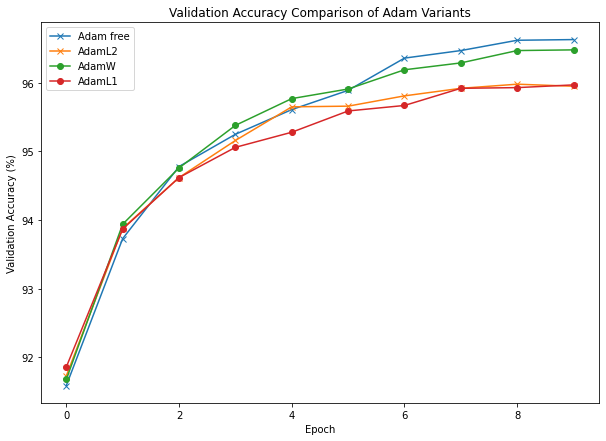

In [11]:
# Plotting the loss
plt.figure(figsize=(10, 7))
plt.plot(adam_loss_0, '-x', label='Adam free')
plt.plot(adamL2_loss, '-x', label='AdamL2')
plt.plot(adamW_loss, '-o', label='AdamW')
plt.plot(adamL1_loss, '-o', label='AdamL1')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.yscale('log')
plt.title('Validation Loss Comparison of Adam Variants')
plt.show()



# Plotting the accuracy
plt.figure(figsize=(10, 7))
plt.plot(adam_accuracy_0, '-x', label='Adam free')
plt.plot(adamL2_accuracy, '-x', label='AdamL2')
plt.plot(adamW_accuracy, '-o', label='AdamW')
plt.plot(adamL1_accuracy, '-o', label='AdamL1')


plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.legend()
plt.title('Validation Accuracy Comparison of Adam Variants')
plt.show()

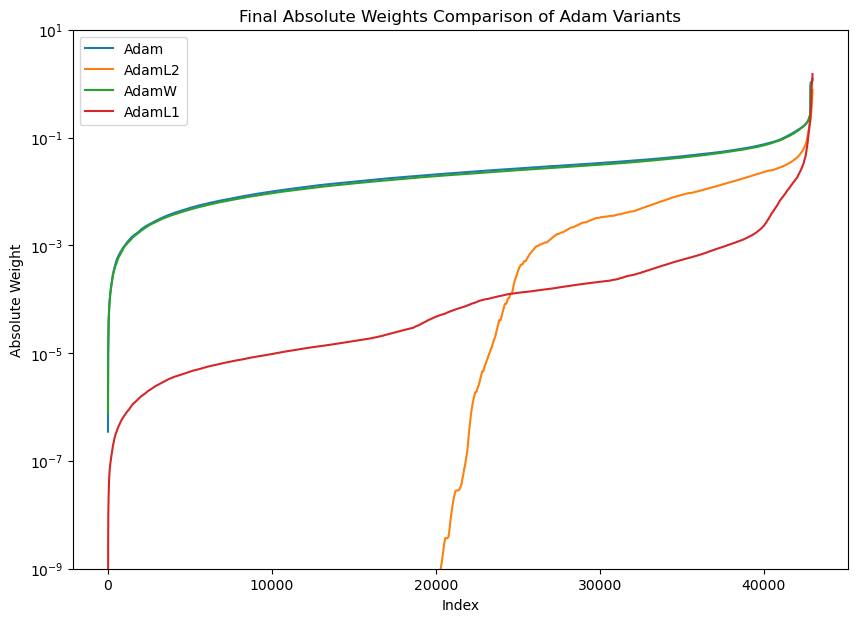

In [295]:
# Plotting the final sorted absolute weights
plt.figure(figsize=(10, 7))
# plt.semilogy(adam_final_weights_0, label='Adam free Final')
plt.semilogy(get_sorted_weights(adam_model_0), label='Adam')
plt.semilogy(get_sorted_weights(adamL2_model), label='AdamL2')
plt.semilogy(get_sorted_weights(adamW_model), label='AdamW')
plt.semilogy(get_sorted_weights(adamL1_model), label='AdamL1')

plt.xlabel('Index')
plt.ylabel('Absolute Weight')
plt.legend()
plt.title('Final Absolute Weights Comparison of Adam Variants')
plt.ylim(1e-9, 1e1)
plt.show()

In [298]:
prune_step = 300
adam_accuracies = evaluate_and_prune(adam_model_0, test_loader,prune_step=prune_step)
adamL2_accuracies = evaluate_and_prune(adamL2_model, test_loader,prune_step=prune_step)
adamW_accuracies = evaluate_and_prune(adamW_model, test_loader,prune_step=prune_step)
adamL1_accuracies = evaluate_and_prune(adamL1_model, test_loader,prune_step=prune_step)


100%|██████████| 144/144 [01:09<00:00,  2.07it/s]


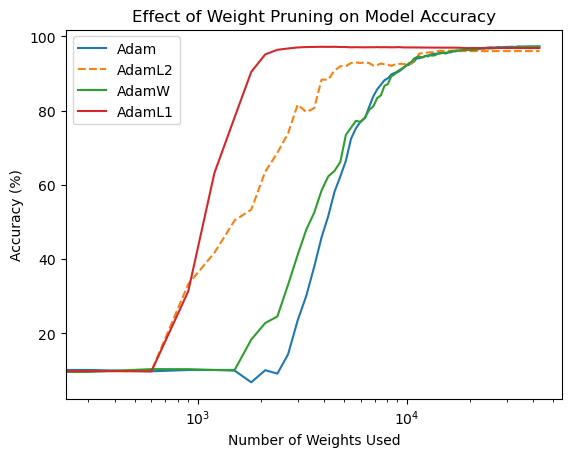

In [314]:

x_values = [i*prune_step for i in range(len(adam_accuracies))]

# Plotting
plt.semilogx(x_values, adam_accuracies[::-1], label='Adam')
plt.plot(x_values, adamL2_accuracies[::-1], label='AdamL2',ls='--')
plt.plot(x_values, adamW_accuracies[::-1], label='AdamW')
plt.plot(x_values, adamL1_accuracies[::-1], label='AdamL1')


plt.xlabel('Number of Weights Used')
plt.ylabel('Accuracy (%)')
plt.title('Effect of Weight Pruning on Model Accuracy')
plt.legend()
plt.show()

In [303]:
def evaluate_accuracy_on_inverted(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in data_loader:
            inverted_data = -data  # negate the tensor to invert the color
            output = model(inverted_data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return 100 * correct / total

accuracy_on_inverted = evaluate_accuracy_on_inverted(adamW_model, test_loader)
print(f'Accuracy on inverted data: {accuracy_on_inverted}%')


Accuracy on inverted data: 7.36%


In [304]:
torch.tensor(adam_final_weights).pow(2).sum()*0.002,torch.tensor(adamL1_final_weights).abs().sum()*0.002

(tensor(0.0491), tensor(0.0658))

# Resnet Experiments

In [4]:
# # Dowload the dataset
# dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
# download_url(dataset_url, '.')

# # Extract from archive
# with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
#     tar.extractall(path='./data')
    
# Look into the data directory
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['train', 'test']
['bird', 'horse', 'dog', 'frog', 'airplane', 'ship', 'cat', 'automobile', 'deer', 'truck']


In [5]:
# Data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                        #  tt.RandomRotation(degrees=30), 
                        #  tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                        #  tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

# PyTorch datasets
train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/test', valid_tfms)

# data loaders
batch_size = 64
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=2, pin_memory=True)

In [6]:
# Prepare to use GPU

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


# Adjust the data
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [7]:
# Utility function to calculate accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Base class for image classification models
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Compute loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Compute loss
        acc = accuracy(out, labels)           # Compute accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

# Function to create a convolutional block with optional pooling
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

# ResNet9 model class
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)                 # First convolutional block
        self.conv2 = conv_block(64, 128, pool=True)              # Second convolutional block with pooling
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))  # First residual block
        
        self.conv3 = conv_block(128, 256, pool=True)             # Third convolutional block with pooling
        self.conv4 = conv_block(256, 512, pool=True)             # Fourth convolutional block with pooling
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))  # Second residual block

        self.classifier = nn.Sequential(
            nn.MaxPool2d(4),  # Global Max Pooling
            nn.Flatten(),     # Flatten the tensor
            nn.Dropout(0.2),  # Dropout layer
            nn.Linear(512, num_classes)  # Fully connected layer
        )
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out  # Skip connection over res1
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out  # Skip connection over res2
        out = self.classifier(out)  # Final classification
        return out


In [8]:
model = to_device(ResNet9(3, 10), device)
print(f'The model has {count_parameters(model):,} trainable parameters.')

The model has 6,573,130 trainable parameters.


In [9]:
import torch
from torch import nn

@torch.no_grad()
def evaluate(model, val_loader):
    """
    Evaluate the model's performance on the validation set.
    """
    model.eval()  # Set the model to evaluation mode
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    """
    Retrieve the current learning rate from the optimizer.
    """
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    """
    Train a model using the one-cycle policy.
    """
    torch.cuda.empty_cache()  # Clear unused CUDA memory
    history = []
    
    # Initialize custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    
    # Initialize one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        train_losses = []  # Store training losses
        lrs = []  # Store learning rates

        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping, if specified
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record and update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation Phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history


In [ ]:
history = [evaluate(model, valid_dl)]
history

In [1]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.AdamW

NameError: name 'torch' is not defined

In [11]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

RuntimeError: MPS backend out of memory (MPS allocated: 241.74 MB, other allocations: 36.04 GB, max allowed: 36.27 GB). Tried to allocate 8.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

# Old and slow resnet

In [9]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes):
        super(BasicBlock, self).__init__()
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_planes, planes, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(planes),
            nn.ReLU(),
            nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(planes)
        )
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_planes, planes, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(planes),
            nn.ReLU(),
            nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(planes)
        )
        
    def forward(self, x):
        out1 = self.branch1(x)
        out2 = self.branch2(x)
        out = out1 + out2
        return nn.ReLU()(out)  # apply ReLU after summing

# class ResNet(nn.Module):
#     def __init__(self, num_classes=10):
#         super(ResNet, self).__init__()
#         self.layer1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
#         self.residual_blocks = self._make_layer(64, 12)
#         self.layer2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
#         self.fc = nn.Linear(128, num_classes)
        
#     def _make_layer(self, planes, num_blocks):
#         layers = []
#         for _ in range(num_blocks):
#             layers.append(BasicBlock(planes, planes))
#         return nn.Sequential(*layers)
        
#     def forward(self, x):
#         out = self.layer1(x)
#         out = self.residual_blocks(out)
#         out = self.layer2(out)
#         out = nn.functional.adaptive_avg_pool2d(out, (1, 1))
#         out = out.view(out.size(0), -1)
#         out = self.fc(out)
#         return out

class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()
        self.layer1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        
        # Create 12 residual blocks for the first layer
        self.residual_blocks1 = self._make_layer(64, 12)
        
        # Increase width and add another 12 residual blocks
        self.layer2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.residual_blocks2 = self._make_layer(128, 12)

        self.fc = nn.Linear(128, num_classes)

    def _make_layer(self, planes, num_blocks):
        layers = []
        for _ in range(num_blocks):
            layers.append(BasicBlock(planes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.layer1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.residual_blocks1(out)
        
        out = self.layer2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        out = self.residual_blocks2(out)
        
        out = nn.functional.adaptive_avg_pool2d(out, (1, 1))
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


# Function to count number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Instantiate the model and count parameters
model = ResNet()
print(f'The model has {count_parameters(model):,} trainable parameters.')


The model has 8,952,330 trainable parameters.


In [10]:
# Data Preprocessing with Augmentation
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the CIFAR-10 dataset
trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

# Classes in CIFAR-10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


In [11]:
model = ResNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.1/125, weight_decay=0.001/4)


num_epochs = 10

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % 100 == 99:  # Print average loss every 100 mini-batches
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
            running_loss = 0.0

    # After each epoch, evaluate the model on the test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Accuracy of the network on the 10000 test images: {100 * correct / total}%")

print("Finished Training")


  0%|          | 0/10 [00:00<?, ?it/s]

[1, 100] loss: 2.099
[1, 200] loss: 1.942
[1, 300] loss: 1.859


 10%|█         | 1/10 [16:18<2:26:48, 978.73s/it]

Accuracy of the network on the 10000 test images: 27.92%
[2, 100] loss: 1.754
[2, 200] loss: 1.706
[2, 300] loss: 1.666


 20%|██        | 2/10 [32:29<2:09:50, 973.83s/it]

Accuracy of the network on the 10000 test images: 32.91%
[3, 100] loss: 1.586
[3, 200] loss: 1.627
[3, 300] loss: 1.609


 30%|███       | 3/10 [48:43<1:53:38, 974.06s/it]

Accuracy of the network on the 10000 test images: 37.11%
[4, 100] loss: 1.533
[4, 200] loss: 1.507
[4, 300] loss: 1.482


 40%|████      | 4/10 [1:04:50<1:37:08, 971.44s/it]

Accuracy of the network on the 10000 test images: 39.89%
[5, 100] loss: 1.426
[5, 200] loss: 1.405
[5, 300] loss: 1.382
Accuracy of the network on the 10000 test images: 43.36%


 50%|█████     | 5/10 [1:20:57<1:20:48, 969.67s/it]

[6, 100] loss: 1.339
[6, 200] loss: 1.287
[6, 300] loss: 1.300


 60%|██████    | 6/10 [1:37:17<1:04:52, 973.05s/it]

Accuracy of the network on the 10000 test images: 39.89%
[7, 100] loss: 1.255
[7, 200] loss: 1.250
[7, 300] loss: 1.248


 70%|███████   | 7/10 [1:53:44<48:52, 977.65s/it]  

Accuracy of the network on the 10000 test images: 49.68%
[8, 100] loss: 1.197
[8, 200] loss: 1.165
[8, 300] loss: 1.145


 80%|████████  | 8/10 [2:09:59<32:33, 976.92s/it]

Accuracy of the network on the 10000 test images: 49.85%
[9, 100] loss: 1.145
[9, 200] loss: 1.139
[9, 300] loss: 1.112


 90%|█████████ | 9/10 [2:26:10<16:15, 975.02s/it]

Accuracy of the network on the 10000 test images: 43.07%
[10, 100] loss: 1.133
[10, 200] loss: 1.064
[10, 300] loss: 1.080


100%|██████████| 10/10 [2:42:27<00:00, 974.80s/it]

Accuracy of the network on the 10000 test images: 57.72%
Finished Training


# Older thing, will get back to this

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Define the Neural Network
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)  # added another hidden layer
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))  # added ReLU activation here
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

# Parameters
BATCH_SIZE = 64
EPOCHS = 10
LR = 0.001
MOMENTUM = 0.9
WEIGHT_DECAY = 0.01  # Regularization strength for both Adam and AdamW
HIDDEN_DIM = 128
INPUT_DIM = 28*28
OUTPUT_DIM = 10

# Load Data
train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Training function
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

# Main
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleNN(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM).to(device)

# Adam Optimizer with L2 regularization
optimizer_adam = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# AdamW Optimizer
optimizer_adamw = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# Train using Adam with L2 regularization
for epoch in trange(1, EPOCHS + 1):
    train(model, device, train_loader, optimizer_adam, epoch)

# (Optional) Reset the model weights here if you want separate runs

# Train using AdamW
for epoch in trange(1, EPOCHS + 1):
    train(model, device, train_loader, optimizer_adamw, epoch)

# (Optional) Evaluation, plots, etc.


100%|██████████| 10/10 [00:25<00:00,  2.57s/it]


100%|██████████| 30/30 [01:04<00:00,  2.15s/it]


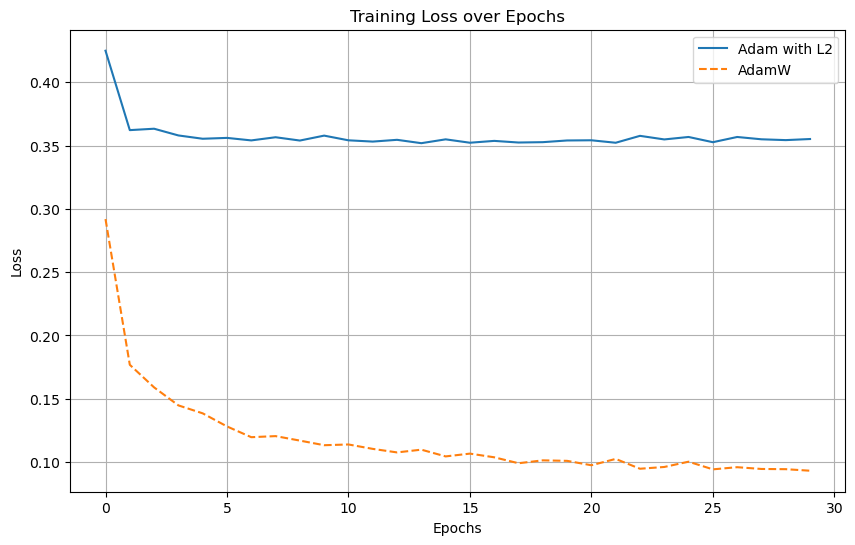

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Define the Neural Network
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Training function
def train(model, device, train_loader, optimizer):
    model.train()
    total_loss = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Plotting function
def plot_losses(adam_losses, adamw_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(adam_losses, label='Adam with L2', linestyle='-')
    plt.plot(adamw_losses, label='AdamW', linestyle='--')
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Parameters
BATCH_SIZE = 64
EPOCHS = 30
LR = 0.01
WEIGHT_DECAY = 0.01
HIDDEN_DIM = 30
INPUT_DIM = 28*28
OUTPUT_DIM = 10

# Load Data
train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Main
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleNN(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM).to(device)

# Adam Optimizer with L2 regularization
optimizer_adam = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# AdamW Optimizer
optimizer_adamw = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# Lists to store average loss per epoch
adam_losses = []
adamw_losses = []

# Train using Adam with L2 regularization
model_copy = SimpleNN(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM).to(device)  # Copy of the initial model weights
model_copy.load_state_dict(model.state_dict())

for epoch in trange(EPOCHS):
    
    loss = train(model, device, train_loader, optimizer_adam)
    adam_losses.append(loss)

# Load the original weights for training with AdamW
model.load_state_dict(model_copy.state_dict())

for epoch in trange(EPOCHS):
    loss = train(model, device, train_loader, optimizer_adamw)
    adamw_losses.append(loss)

plot_losses(adam_losses, adamw_losses)
